In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
!pip install torchvision==0.16.0

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## Get the data

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Prepare transforms for images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


## creating datalaoders

In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7aa234d89ba0>,
 ['pizza', 'steak', 'sushi'])

# Visualize a single image

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(0))

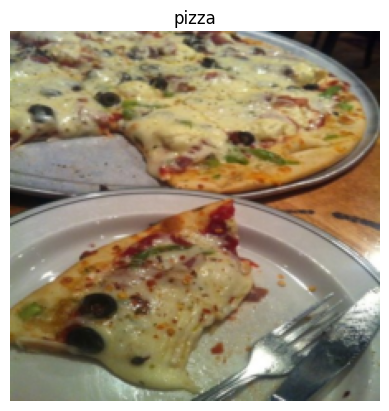

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Replicating Vit : Overview

### 3.2 Getting specific: What's ViT made of?

There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:
1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast.

> **Note:** We're going to be focused on writing PyTorch code to create these layers. For the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

### 3.3 My workflow for replicating papers

When I start working on replicating a paper, I go through the following steps:

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use [mathpix.com](https://mathpix.com/) (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-mathpix-demo.gif" width=900 alt="using mathpix.com to turn text from a machine learning research paper (PDF) into editable LaTeX"/>

*Turning the four equations from the ViT paper into editable LaTeX/markdown using [mathpix.com](https://mathpix.com/).*

We've already gone through the first few steps above (and if you haven't read the full paper yet, I'd encourage you to give it a go) but what we'll be focusing on next is step 5: replicating the simplest version of the model possible.

This is why we're starting with ViT-Base.

Replicating the smallest version of the architecture possible, get it working and then we can scale up if we wanted to.

> **Note:** If you've never read a research paper before, many of the above steps can be intimidating. But don't worry, like anything, your skills at reading *and* replicating papers will improve with practice. Don't forget, a research paper is often *months* of work by many people compressed into a few pages. So trying to replicate it on your own is no small feat.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector.

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper:

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### turning single images into patches
let's visualise

(-0.5, 223.5, 223.5, -0.5)

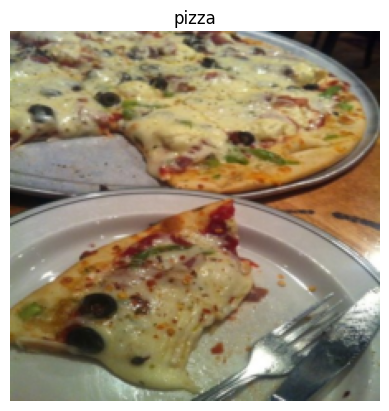

In [12]:
# view a single imaghe
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

### COnverting top row as patches

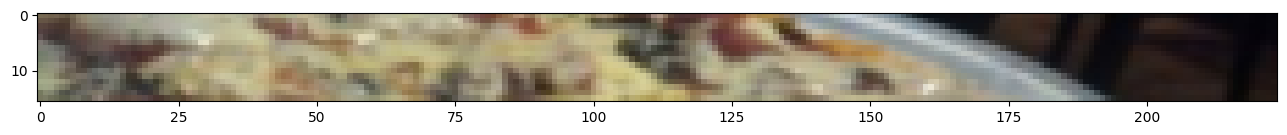

In [13]:
# get the top row of the uimage
image_permuted = image.permute(1,2,0)

# index to plot the top row of the pixels
patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


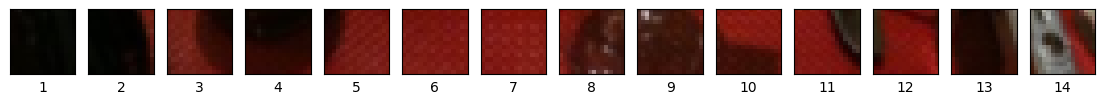

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### create patches of the whole image

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


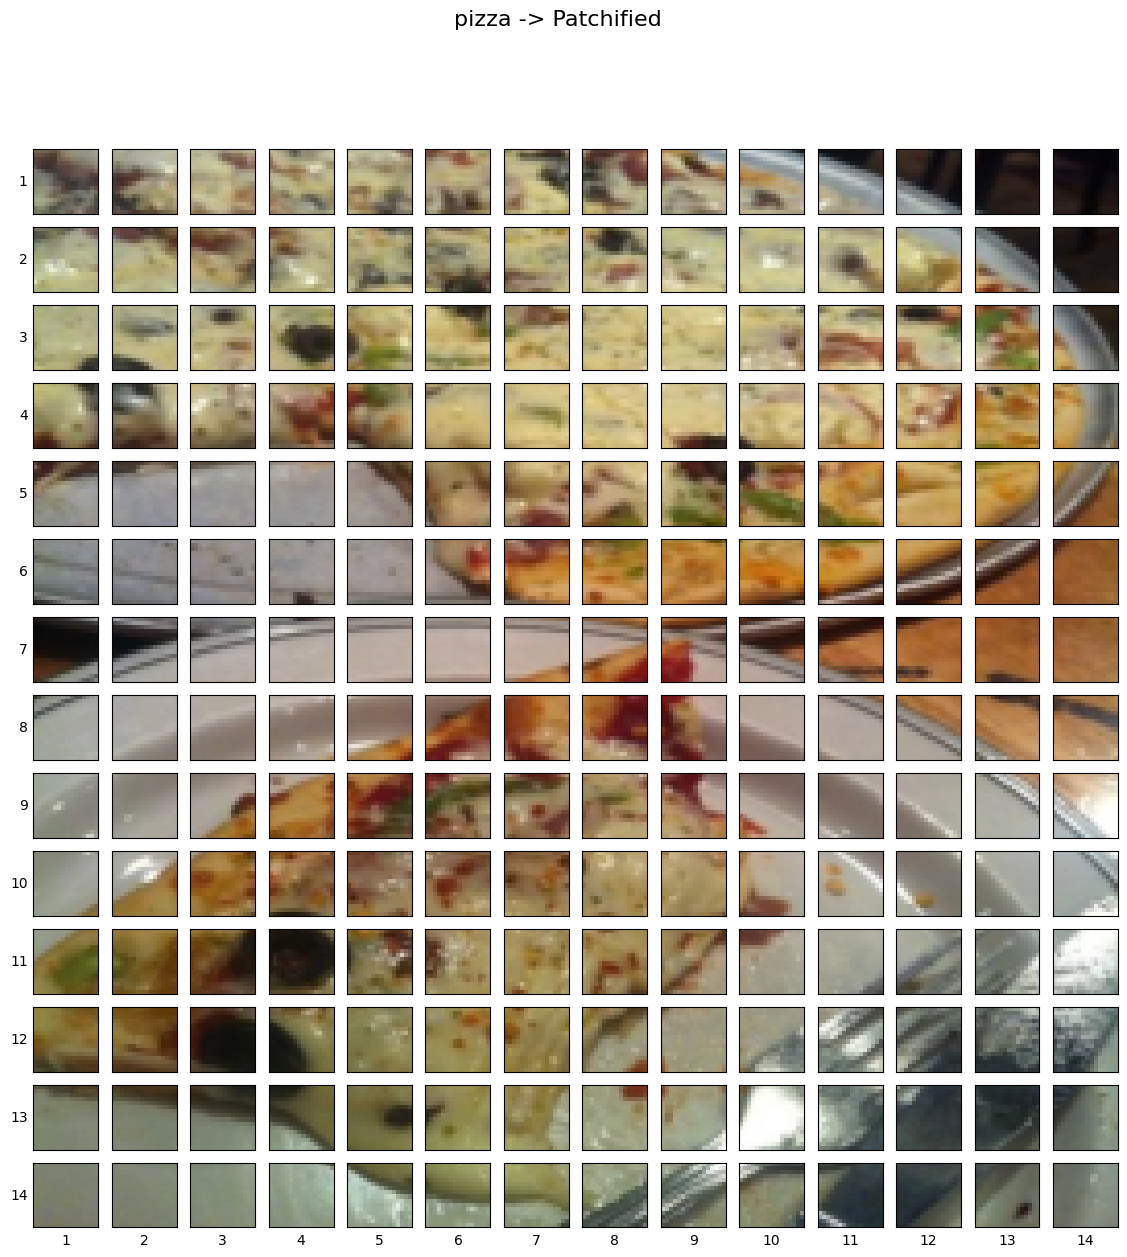

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### creating image patches and tuening them into patches using conv2d

In [15]:
# create conv2d layer to turn them into opatches
from torch import nn
patch_size=16


conv2d = nn.Conv2d(in_channels=3,out_channels=768,#d size from table 1
                   kernel_size=patch_size,stride=patch_size,
                   padding=0
                   )
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

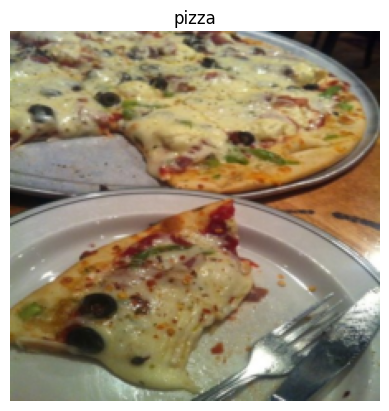

In [16]:
# view single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

In [17]:
# pass the image throughr the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [409, 66, 355, 197, 463]


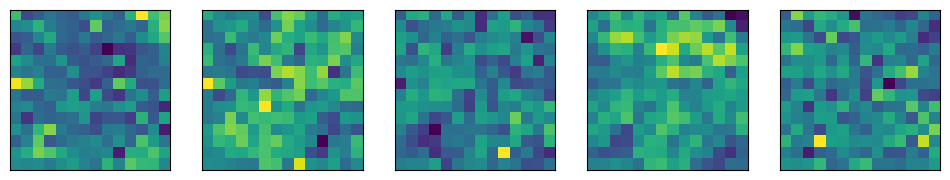

In [18]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [19]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0262, -0.0797, -0.2076, -0.1920, -0.2366, -0.2599, -0.2064,
           -0.1654, -0.1877, -0.1907, -0.1591, -0.1388, -0.0125, -0.0694],
          [-0.2020, -0.1699, -0.2190, -0.1382, -0.1940, -0.1301, -0.2134,
           -0.1393, -0.2810, -0.1959, -0.2068, -0.2505, -0.1259, -0.1327],
          [-0.1966, -0.0837, -0.2525, -0.3250, -0.1774, -0.2243, -0.1174,
           -0.2574, -0.2647, -0.2703, -0.2586, -0.1375, -0.1936, -0.1680],
          [-0.1378, -0.1385, -0.2017, -0.1744, -0.0793, -0.2022, -0.1757,
           -0.2209, -0.3140, -0.1282, -0.1890, -0.2513, -0.1748, -0.2761],
          [-0.1995, -0.1574, -0.1565, -0.1670, -0.2288, -0.0924, -0.1773,
           -0.1442, -0.2357, -0.2551, -0.0746, -0.1927, -0.2092, -0.1680],
          [-0.1513, -0.1715, -0.1594, -0.2449, -0.1841, -0.1396, -0.0267,
           -0.1137, -0.1118, -0.1315, -0.1781, -0.2699, -0.1174, -0.0835],
          [-0.0024, -0.0327, -0.1631, -0.1614, -0.2104, -0.2104, -0.2158,
           -0.1235, -0.0623, -0.

In [20]:
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


## Flattening laeyr

In [21]:
flatten_layer = nn.Flatten(start_dim=2,end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

### Put everything together

## want: batch_size, numof_patches, embdeein_dim

og shape of the image:torch.Size([3, 224, 224])
image feature map patches shape:torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])


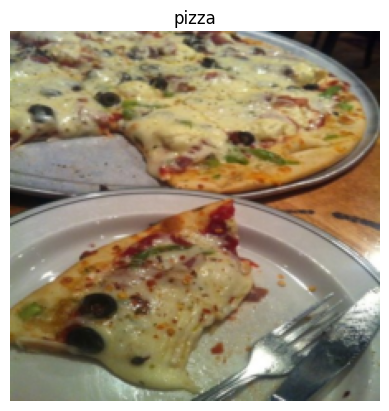

In [22]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")
print(f"og shape of the image:{image.shape}")


# turn image into feature maps
image_out_of_conv  = conv2d(image.unsqueeze(0))
print(f"image feature map patches shape:{image_out_of_conv.shape}")


# flaten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(image_out_of_conv_flattened.shape)


In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


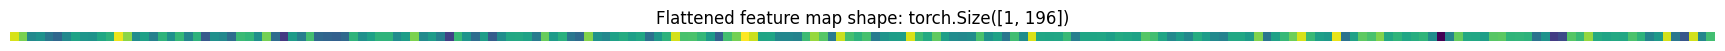

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [25]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0262, -0.0797, -0.2076, -0.1920, -0.2366, -0.2599, -0.2064, -0.1654,
          -0.1877, -0.1907, -0.1591, -0.1388, -0.0125, -0.0694, -0.2020, -0.1699,
          -0.2190, -0.1382, -0.1940, -0.1301, -0.2134, -0.1393, -0.2810, -0.1959,
          -0.2068, -0.2505, -0.1259, -0.1327, -0.1966, -0.0837, -0.2525, -0.3250,
          -0.1774, -0.2243, -0.1174, -0.2574, -0.2647, -0.2703, -0.2586, -0.1375,
          -0.1936, -0.1680, -0.1378, -0.1385, -0.2017, -0.1744, -0.0793, -0.2022,
          -0.1757, -0.2209, -0.3140, -0.1282, -0.1890, -0.2513, -0.1748, -0.2761,
          -0.1995, -0.1574, -0.1565, -0.1670, -0.2288, -0.0924, -0.1773, -0.1442,
          -0.2357, -0.2551, -0.0746, -0.1927, -0.2092, -0.1680, -0.1513, -0.1715,
          -0.1594, -0.2449, -0.1841, -0.1396, -0.0267, -0.1137, -0.1118, -0.1315,
          -0.1781, -0.2699, -0.1174, -0.0835, -0.0024, -0.0327, -0.1631, -0.1614,
          -0.2104, -0.2104, -0.2158, -0.1235, -0.0623, -0.1041, -0.2288, -0.0328,
          -0.116

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

We can do so by subclassing `nn.Module` and creating a small PyTorch "model" to do all of the steps above.

Specifically we'll:
1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

Let's do it!

In [26]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [27]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [28]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(),
#         input_size=random_input_image, # try swapping this for "random_input_image_error"
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 4.6 Creating the class token embedding

Okay we've made the image patch embedding, time to get to work on the class token embedding.

Or $\mathbf{x}_\text {class }$ from equation 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png" width=900 alt="class token embedding highlight from the vision transformer paper figure 1 and section 3.1"/>

*Left: Figure 1 from the ViT paper with the "classification token" or `[class]` embedding token we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the learnable class embedding token.*

Reading the second paragraph of section 3.1 from the ViT paper, we see the following description:

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

So we need to "preprend a learnable embedding to the sequence of embedded patches".

Let's start by viewing our sequence of embedded patches tensor (created in section 4.5) and its shape.

In [29]:
patch_embedded_image

tensor([[[-0.3293,  0.1910, -0.1129,  ...,  0.2747, -0.2131,  0.2206],
         [-0.5811,  0.1648,  0.0534,  ...,  0.5096, -0.3761,  0.0302],
         [-0.6164,  0.0924, -0.1474,  ...,  0.4400, -0.3777,  0.3175],
         ...,
         [-0.3190,  0.0675, -0.0671,  ...,  0.2411, -0.1437,  0.0783],
         [-0.5004,  0.1051, -0.1623,  ...,  0.2821, -0.1280,  0.2103],
         [-0.5223,  0.2058, -0.1498,  ...,  0.4200, -0.2228,  0.1045]]],
       grad_fn=<PermuteBackward0>)

In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [31]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3293,  0.1910, -0.1129,  ...,  0.2747, -0.2131,  0.2206],
         [-0.5811,  0.1648,  0.0534,  ...,  0.5096, -0.3761,  0.0302],
         ...,
         [-0.3190,  0.0675, -0.0671,  ...,  0.2411, -0.1437,  0.0783],
         [-0.5004,  0.1051, -0.1623,  ...,  0.2821, -0.1280,  0.2103],
         [-0.5223,  0.2058, -0.1498,  ...,  0.4200, -0.2228,  0.1045]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Create position embedding

In [33]:
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3293,  0.1910, -0.1129,  ...,  0.2747, -0.2131,  0.2206],
          [-0.5811,  0.1648,  0.0534,  ...,  0.5096, -0.3761,  0.0302],
          ...,
          [-0.3190,  0.0675, -0.0671,  ...,  0.2411, -0.1437,  0.0783],
          [-0.5004,  0.1051, -0.1623,  ...,  0.2821, -0.1280,  0.2103],
          [-0.5223,  0.2058, -0.1498,  ...,  0.4200, -0.2228,  0.1045]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [34]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6707, 1.1910, 0.8871,  ..., 1.2747, 0.7869, 1.2206],
         [0.4189, 1.1648, 1.0534,  ..., 1.5096, 0.6239, 1.0302],
         ...,
         [0.6810, 1.0675, 0.9329,  ..., 1.2411, 0.8563, 1.0783],
         [0.4996, 1.1051, 0.8377,  ..., 1.2821, 0.8720, 1.2103],
         [0.4777, 1.2058, 0.8502,  ..., 1.4200, 0.7772, 1.1045]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### putting it all together
This means we are going to do all the things like word embedding, position embedding and patchifying all togehter

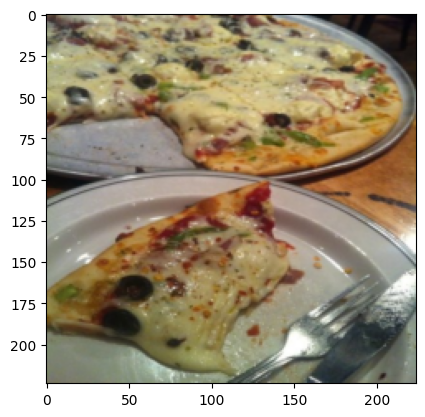

In [36]:
plt.imshow(image.permute(1,2,0))
# plt.title(class_names)

# Equation one
$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$


In [37]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


**First equation done**

###Equation 2 Multihead self attention
$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

## 5. Equation 2: Multi-Head Attention (MSA)

We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

To start, we'll break down the Transformer Encoder section into two parts (start small and increase when necessary).

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

We'll refer to equation 2 as the "MSA block".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

***Left:** Figure 1 from the ViT paper with Multi-Head Attention and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. **Right:** Mapping the Multi-Head Self Attention (MSA) layer, Norm layer and residual connection to their respective parts of equation 2 in the ViT paper.*

Many layers you find in research papers are already implemented in modern deep learning frameworks such as PyTorch.

In saying this, to replicate these layers and residual connection with PyTorch code we can use:
* **Multi-Head Self Attention (MSA)** - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **Norm (LN or LayerNorm)** - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Residual connection** - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).

### 5.1 The LayerNorm (LN) layer

[Layer Normalization](https://paperswithcode.com/method/layer-normalization) (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

You can find the formal definition of `torch.nn.LayerNorm()` in the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

PyTorch's `torch.nn.LayerNorm()`'s main parameter is `normalized_shape` which we can set to be equal to the dimension size we'd like to noramlize over (in our case it'll be $D$ or `768` for ViT-Base).

What does it do?

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples into a similar distribution".

Imagine trying to walk up (or down) a set of stairs all with differing heights and lengths.

It'd take some adjustment on each step right?

And what you learn for each step wouldn't necessary help with the next one since they all differ, increasing the time it takes you to navigate the stairs.

Normalization (including Layer Normalization) is the equivalent of making all the stairs the same height and length except the stairs are your data samples.

So just like you can walk up (or down) stairs with similar heights and lengths much easier than those with unequal heights and widths, neural networks can optimize over data samples with similar distributions (similar mean and standard-deviations) easier than those with varying distributions.

In [38]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base( an the same in the gpt)
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [39]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12)

# pass the patch and position image embedding sequence throuhh msa block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [40]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6707, 1.1910, 0.8871,  ..., 1.2747, 0.7869, 1.2206],
         [0.4189, 1.1648, 1.0534,  ..., 1.5096, 0.6239, 1.0302],
         ...,
         [0.6810, 1.0675, 0.9329,  ..., 1.2411, 0.8563, 1.0783],
         [0.4996, 1.1051, 0.8377,  ..., 1.2821, 0.8720, 1.2103],
         [0.4777, 1.2058, 0.8502,  ..., 1.4200, 0.7772, 1.1045]]],
       grad_fn=<AddBackward0>)

In [41]:
patched_image_through_msa_block

tensor([[[-0.2248, -0.2351,  0.0650,  ..., -0.4313,  0.8840, -0.4859],
         [-0.2194, -0.2289,  0.0711,  ..., -0.4307,  0.8909, -0.4970],
         [-0.2205, -0.2325,  0.0686,  ..., -0.4326,  0.8908, -0.4952],
         ...,
         [-0.2209, -0.2286,  0.0715,  ..., -0.4316,  0.8909, -0.4949],
         [-0.2202, -0.2254,  0.0722,  ..., -0.4305,  0.8918, -0.4977],
         [-0.2197, -0.2286,  0.0708,  ..., -0.4323,  0.8913, -0.4976]]],
       grad_fn=<TransposeBackward0>)

### Now we will pass these tensor to nn to learn the context. we will cerate a MLP

## 6. Equation 3: Multilayer Perceptron (MLP)

We're on a roll here!

Let's keep it going and replicate equation 3:

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder (notice how we're continuing the trend of breaking down the architecture into smaller chunks).

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png" alt="mapping equation 3 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

***Left:** Figure 1 from the ViT paper with MLP and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. **Right:** Mapping the multilayer perceptron (MLP) layer, Norm layer (LN) and residual connection to their respective parts of equation 3 in the ViT paper.*

### 6.1 The MLP layer(s)

The term [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) is quite broad as it can refer to almost any combination of *multiple* layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

> The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers ([`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) and "GELU non-linearity" is the GELU  (Gaussian Error Linear Units) non-linear activation function ([`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) in PyTorch).

> **Note:** A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer ([`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) in PyTorch).

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, `dropout=0.1`).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size $D$ is the output size of the MLP block).

### 6.2 Replicating Equation 3 with PyTorch layers

Let's put everything we've discussed about the LayerNorm (LN) and MLP (MSA) layers in equation 3 into practice.

To do so, we'll:  

1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a sequential series of MLP layers(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [42]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [43]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [44]:
patched_image_through_msa_block

tensor([[[-0.2248, -0.2351,  0.0650,  ..., -0.4313,  0.8840, -0.4859],
         [-0.2194, -0.2289,  0.0711,  ..., -0.4307,  0.8909, -0.4970],
         [-0.2205, -0.2325,  0.0686,  ..., -0.4326,  0.8908, -0.4952],
         ...,
         [-0.2209, -0.2286,  0.0715,  ..., -0.4316,  0.8909, -0.4949],
         [-0.2202, -0.2254,  0.0722,  ..., -0.4305,  0.8918, -0.4977],
         [-0.2197, -0.2286,  0.0708,  ..., -0.4323,  0.8913, -0.4976]]],
       grad_fn=<TransposeBackward0>)

In [45]:
patched_image_through_mlp_block

tensor([[[-0.0539, -0.0193,  0.1668,  ...,  0.0000, -0.1697,  0.1853],
         [-0.1024, -0.1246,  0.2784,  ..., -0.0669, -0.1356,  0.2140],
         [-0.0121, -0.0640,  0.2910,  ..., -0.0000, -0.2046,  0.1989],
         ...,
         [-0.1998, -0.0134,  0.2847,  ...,  0.1558, -0.2105,  0.2881],
         [-0.1304,  0.0410,  0.0000,  ...,  0.0834, -0.1893,  0.0816],
         [-0.0661, -0.0365,  0.2370,  ..., -0.0770, -0.1792,  0.1783]]],
       grad_fn=<MulBackward0>)

## 7. Create the Transformer Encoder

Time to stack together our `MultiheadSelfAttentionBlock` (equation 2) and `MLPBlock` (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an ["encoder" or "auto encoder"](https://paperswithcode.com/method/autoencoder) generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019).

We've created MSA and MLP blocks but what about the residual connections?

[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), were first introduced in the paper [*Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output.

Where the subsequence output might be one or more layers later.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

Or in pseudocode:

`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

What does this do?

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

> **Note:** The iconic computer vision architecture "ResNet" is named so because of the introduction of *res*idual connections. You can find many pretrained versions of ResNet architectures in [`torchvision.models`](https://pytorch.org/vision/stable/models.html).

### 7.1 Creating a Transformer Encoder by combining our custom made layers

Enough talk, let's see this in action and make a ViT Transformer Encoder with PyTorch by combining our previously created layers.

To do so, we'll:  

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our `MultiheadSelfAttentionBlock` from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our `MLPBlock` from section 6.2 with the appropriate parameters.
5. Create a `forward()` method for our `TransformerEncoderBlock` class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [46]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [47]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

So far we've built the components of and the Transformer Encoder layer itself ourselves.

But because of their rise in popularity and effectiveness, PyTorch now has in-built [Transformer layers as part of `torch.nn`](https://pytorch.org/docs/stable/nn.html#transformer-layers).

For example, we can recreate the `TransformerEncoderBlock` we just created using [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and setting the same hyperparameters as above.

In [48]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [49]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-summary-output-pytorch-transformer-encoder.png" alt="output summary of PyTorch's implementation of the Transformer Encoder layer" width=900/>

The output of the summary is slightly different to ours due to how `torch.nn.TransformerEncoderLayer()` constructs its layer.

But the layers it uses, number of parameters and input and output shapes are the same.

You might be thinking, "if we could create the Transformer Encoder so quickly with PyTorch layers, why did we bother reproducing equation 2 and 3?"

The answer is: practice.

Now we've replicated a series of equations and layers from a paper, if you need to change the layers and try something different you can.

But there are benefits of using the PyTorch pre-built layers, such as:
* **Less prone to errors** - Generally, if a layer makes it into the PyTorch standard library, its been tested and tried to work.
* **Potentially better performance** - As of July 2022 and PyTorch 1.12, the PyTorch implemented version of `torch.nn.TransformerEncoderLayer()` can see [a speedup of more than 2x on many common workloads](https://pytorch.org/blog/a-better-transformer-for-fast-transformer-encoder-inference/).

Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with [`torch.nn.TransformerEncoder(encoder_layer, num_layers)`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) where:
* `encoder_layer` - The target Transformer Encoder layer created with `torch.nn.TransformerEncoderLayer()`.
* `num_layers` - The number of Transformer Encoder layers to stack together.

### putting it all together  to create Vit

In [50]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [51]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [52]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [53]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
# summary(model=vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Training the VIt

In [55]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604


### 9.4 What our training setup is missing

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 |
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None |
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None |
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |

Even though our ViT architecture is the same as the paper, the results from the ViT paper were achieved using far more data and a more elaborate training scheme than ours.

Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme such as learning rate warmup, learning rate decay and gradient clipping are specifically designed to [prevent overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting) (regularization).

> **Note:** For any technique you're unsure of, you can often quickly find an example by searching "pytorch TECHNIQUE NAME", for exmaple, say you wanted to learn about learning rate warmup and what it does, you could search "pytorch learning rate warmup".

Good news is, there are many pretrained ViT models (using vast amounts of data) available online, we'll see one in action in section 10.

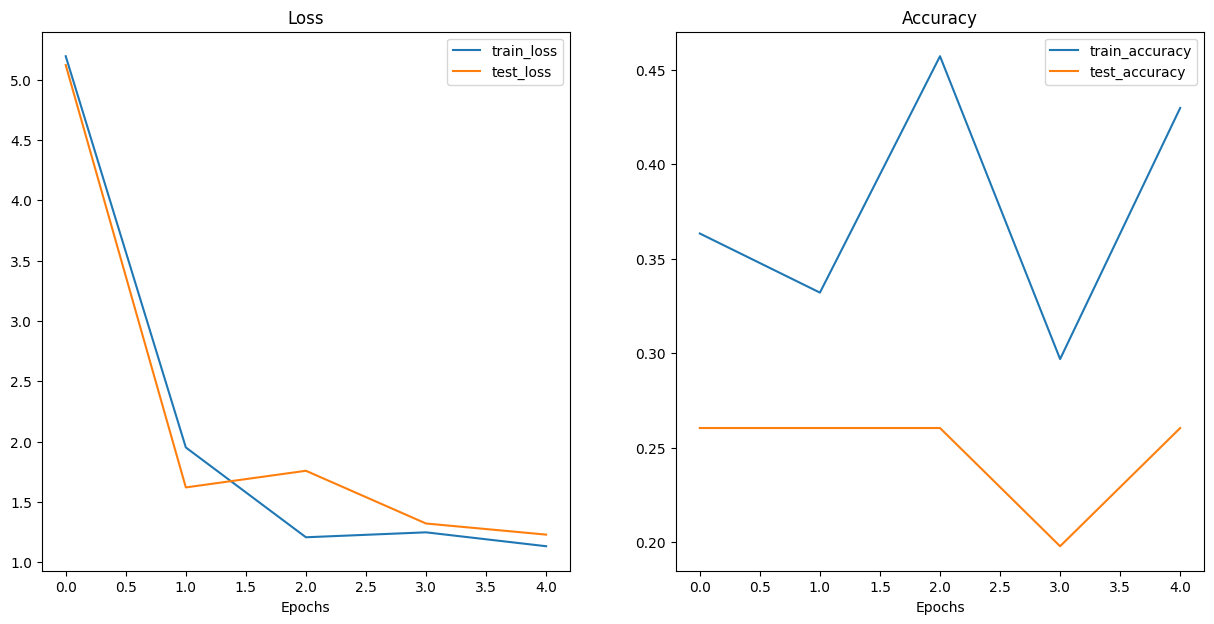

In [56]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

We've discussed the benefits of using pretrained models in [06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/).

But since we've now trained our own ViT from scratch and achieved less than optimal results, the benefits of transfer learning (using a pretrained model) really shine.

### 10.1 Why use a pretrained model?

An important note on many modern machine learning research papers is that much of the results are obtained with large datasets and vast compute resources.

And in modern day machine learning, the original fully trained ViT would likely not be considered a "super large" training setup (models are continually getting bigger and bigger).

Reading the ViT paper section 4.2:

> Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately **30 days**.

As of July 2022, the [price for renting a TPUv3](https://cloud.google.com/tpu/pricing) (Tensor Processing Unit version 3) with 8 cores on Google Cloud is $8 USD per hour.

To rent one for 30 straight days would cost **$5,760 USD**.

This cost (monetary and time) may be viable for some larger research teams or enterprises but for many people it's not.

So having a pretrained model available through resources like [`torchvision.models`](https://pytorch.org/vision/stable/models.html), the [`timm` (Torch Image Models) library](https://github.com/rwightman/pytorch-image-models), the [HuggingFace Hub](https://huggingface.co/models) or even from the authors of the papers themselves (there's a growing trend for machine learning researchers to release the code and pretrained models from their research papers, I'm a big fan of this trend, many of these resources can be found on [Paperswithcode.com](https://paperswithcode.com/)).

If you're focused on leveraging the benefits of a specific model architecture rather than creating your custom architecture, I'd highly recommend using a pretrained model.

In [57]:
import torch
import torchvision


In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
# get pretrained wieghts
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# setup a cit
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
# freeaze the base params
for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False


set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:18<00:00, 18.9MB/s]


In [60]:
# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=pretrained_vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

### 10.3 Preparing data for the pretrained ViT model

We downloaded and created DataLoaders for our own ViT model back in section 2.

So we don't necessarily need to do it again.

But in the name of practice, let's download some image data (pizza, steak and sushi images for Food Vision Mini), setup train and test directories and then transform the images into tensors and DataLoaders.

We can download pizza, steak and sushi images from the course GitHub and the `download_data()` function we creating in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data).
    

In [66]:
# get automatic transforms
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [67]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [68]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [70]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [71]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4 Train feature extractor ViT model

Feature extractor model ready, DataLoaders ready, time to train!

As before we'll use the Adam optimizer (`torch.optim.Adam()`) with a learning rate of `1e-3` and `torch.nn.CrossEntropyLoss()` as the loss function.

Our `engine.train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them) will take care of the rest.

In [72]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


## Plot loss curves

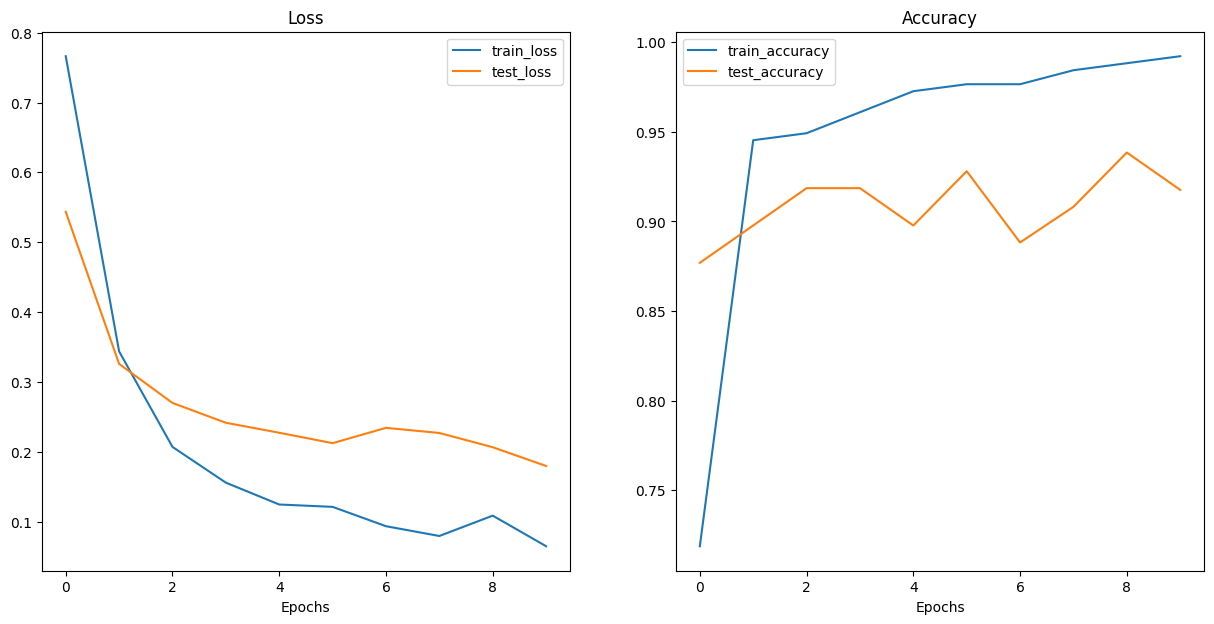

In [74]:
from helper_functions import plot_loss_curves
curves = plot_loss_curves(pretrained_vit_results)
curves


### 10.6 Save feature extractor ViT model and check file size

It looks like our ViT feature extractor model is performing quite well for our Food Vision Mini problem.

Perhaps we might want to try deploying it and see how it goes in production (in this case, deploying means putting our trained model in an application someone could use, say taking photos on their smartphone of food and seeing if our model thinks its pizza, steak or sushi).

To do so we can first save our model with the `utils.save_model()` function we created in [05. PyTorch Going Modular section 5](https://www.learnpytorch.io/05_pytorch_going_modular/#5-creating-a-function-to-save-the-model-utilspy).

In [76]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [77]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Make predictions on a custom image

And finally, we'll finish with the ultimate test, predicting on our own custom data.

Let's download the pizza dad image (a photo of my dad eating pizza) and use our ViT feature extractor to predict on it.

To do we, let's can use the `pred_and_plot()` function we created in [06. PyTorch Transfer Learning section 6](https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set), for convenience, I saved this function to [`going_modular.going_modular.predictions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/predictions.py) on the course GitHub.

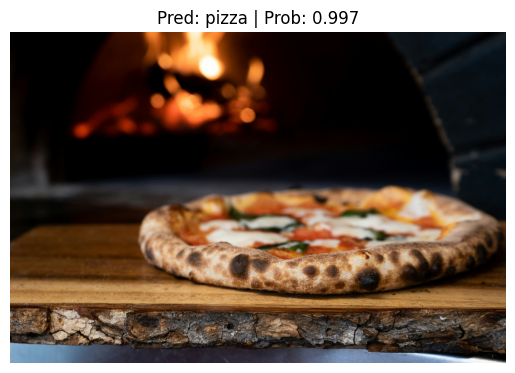

In [86]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "pic2.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/yuvrajkari7/Dog-breed-check/raw/main/Custom_data_tested/n1.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)